### FED3 Starters

This notebook is the starter tutorial for basic functions provided by this package, as our analysis, for convenient inspecting the data and plotted graphs, builds with Jupyter notebooks.

Since many analysis are applied on groups of mice, this notebook has minimal interface of functions provided. For detailed usage, please go through `/CASK_analysis` for two groups of data and `/WT_analysis` for single group of mice.

In [1]:
import sys
sys.path.insert(0, 'scripts')

import os
import numpy as np
import meals as ml
from accuracy import read_and_record, graph_group_stats, plot_cumulative_accuracy
from path import fr1_ctrl_path, fr1_cask_path, fr1_ctrl_sheets, fr1_cask_sheets
from intervals import perform_T_test

### FR1 Accuracy overall inspection

`data` dataframe contains the preprocessed dataframe for each mice's FED3 device recording, and we can see the overall accuracy (removing all pellet events first) and how long it takes to achieve >80% accuracy on choosing the poke for continuous 2 hours.

In [5]:
ctrl_ending_corr = []
ctrl_learned_time = []
ctrl_acc_dict = {}

data = read_and_record(path=fr1_ctrl_path, sheet=fr1_ctrl_sheets[0], 
                        ending_corr=ctrl_ending_corr, 
                        learned_time=ctrl_learned_time,
                        acc_dict=ctrl_acc_dict)
data.head()

,Time,Event,Active_Poke,Pellet_Count,Left_Poke_Count,Right_Poke_Count,Cum_Sum,collect_time,Percent_Correct,Time_passed,time_diff
0,2023-09-06 07:29:08,Pellet,Right,1,1,4,0.004292,46.57,80.000000,0 days 00:00:00,1 days 00:30:00
1,2023-09-06 07:39:08,Right,Right,1,1,5,0.004292,0.00,83.333333,0 days 00:10:00,1 days 00:20:00
2,2023-09-06 07:47:12,Pellet,Right,2,1,5,0.008584,46.57,83.333333,0 days 00:18:04,1 days 00:11:56
3,2023-09-06 07:52:47,Right,Right,2,1,6,0.008584,0.00,85.714286,0 days 00:23:39,1 days 00:06:21
4,2023-09-06 07:55:36,Pellet,Right,3,1,6,0.012876,46.57,85.714286,0 days 00:26:28,1 days 00:03:32


In [7]:
print("Acquisition Time (hours):", ctrl_learned_time[0])
print("Overall Accuracy (%):", ctrl_ending_corr[0])

Acquisition Time (hours): 3.111111111111111
Overall Accuracy (%): 77.88461538461539


### FR1 Feeding

We can plot the histogram of pellet consumption within fine time grids and plot the cumulative pellet(food) consumption throughout the experiment session. The dark span means the inactive periods (in our experiment is 7pm-7am). Blue span on cumulative consumption plot means our meal algorithm detects this period is a meal. Red light on histogram is just an empirical threshold for intense eating, just for reference.

The meta regards this sample is returned by a dictionary.

`dark_meals` means meals proportion happens in inactive periods. It's named 'dark' because in our experiment, mice are adjusted to be inactive at dark/night.

`in_meal_ratio` is the ratio of pellets consumed as part of a meal. 

Other metrics are as name suggested.

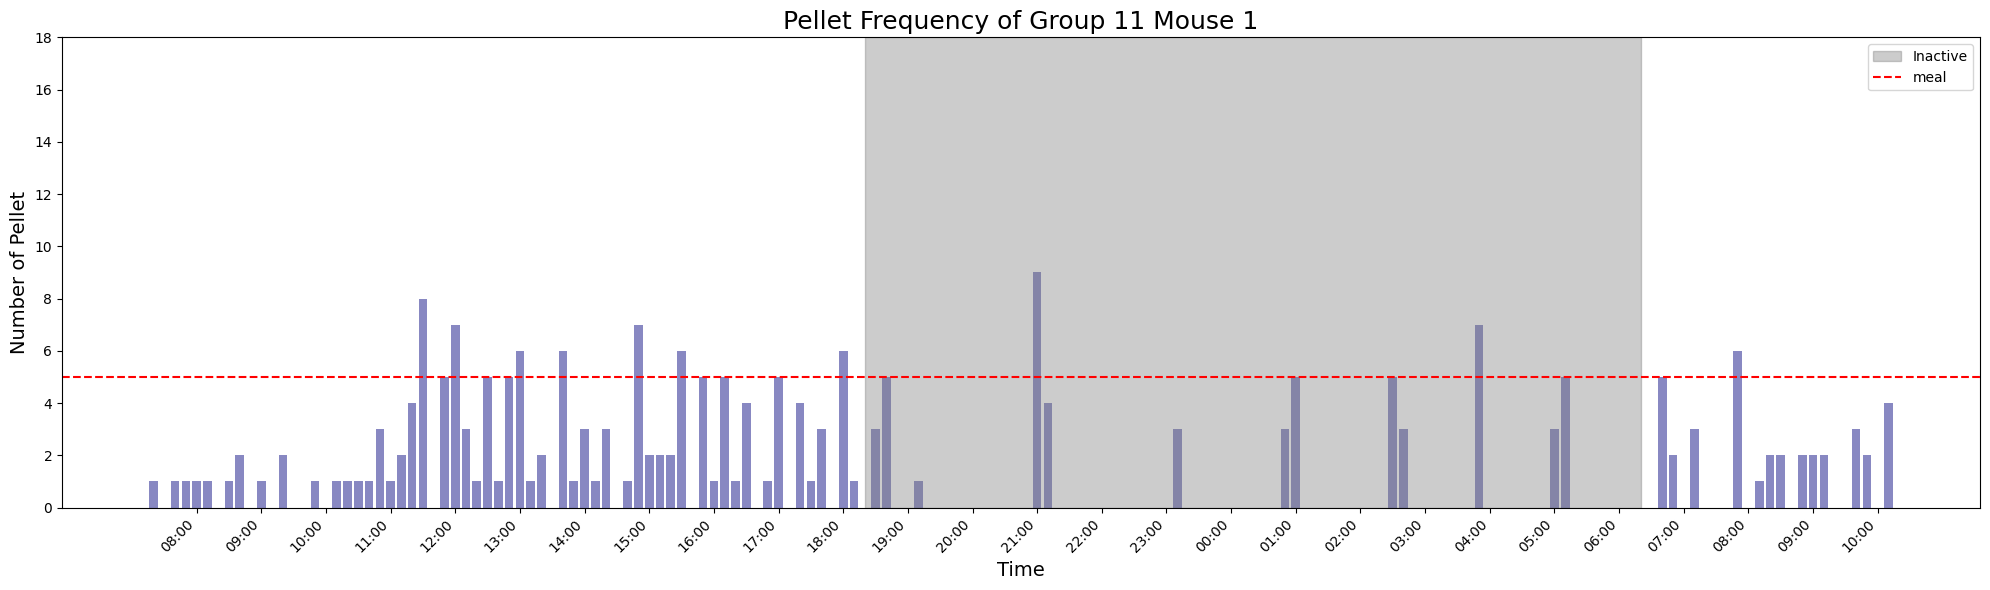

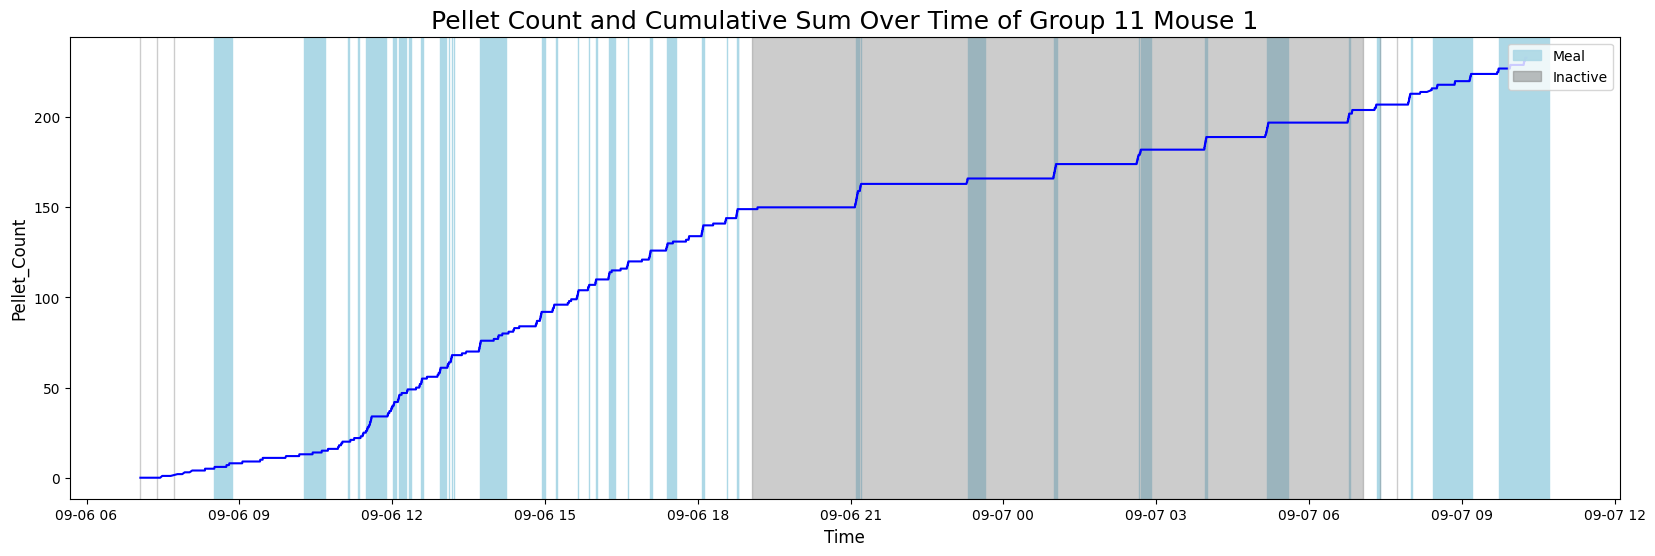

{'avg_pellet': 208.4, 'dark_meals': 0.2105, 'fir_meal': 1.7939444441666668, 'fir_good_meal': 1.7939444441666668, 'meal_count': 50.27, 'in_meal_ratio': 0.6738197424892703}


In [3]:
metrics = ml.process_meal_data(fr1_ctrl_sheets[0], fr1_ctrl_path, is_cask=False, 
                                   export_root=None)
print(metrics)

### Reversal Transition Plot

In [7]:
import direction_transition as dit
from meals import find_meals_paper, find_first_good_meal
from accuracy import graph_group_stats
from preprocessing import read_excel_by_sheet
from path import *
from intervals import mean_pellet_collect_time, plot_retrieval_time_by_block, perform_T_test

time_threshold = 60
pellet_count_threshold = 2

First good meal happens at x% of the session: 0.5652685259707236
First good meal time: 93.7 minutes


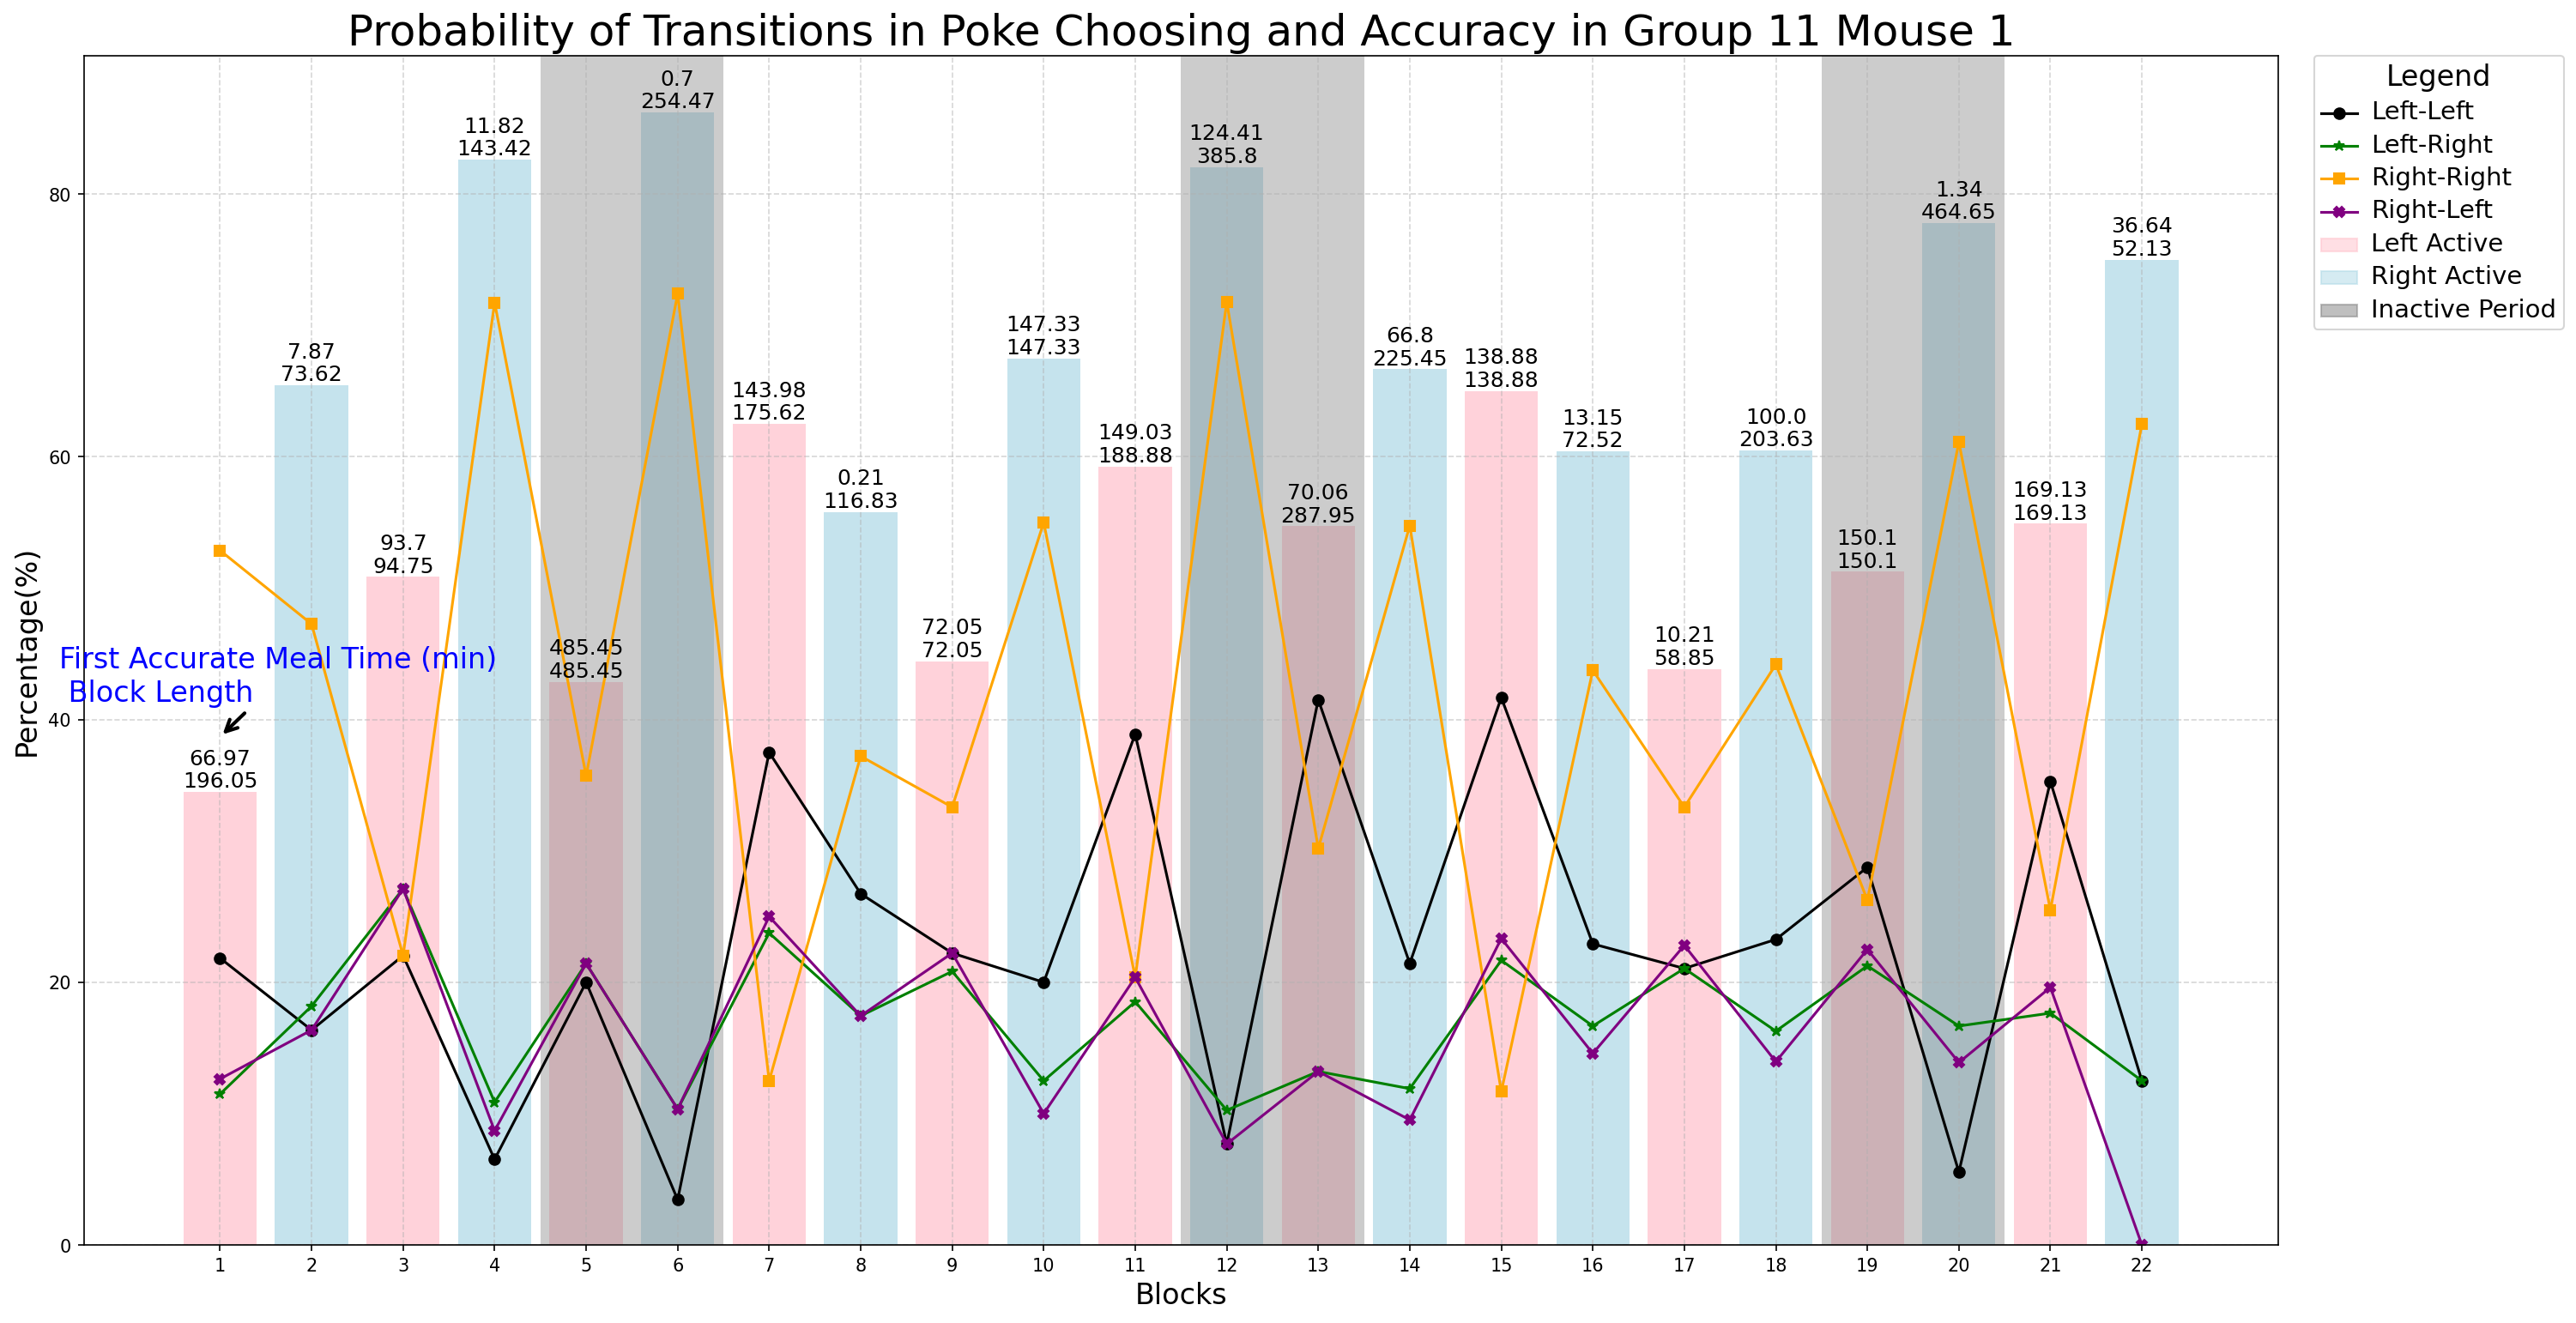

In [10]:
data = read_excel_by_sheet(rev_ctrl_sheets[0], rev_ctrl_path, cumulative_accuracy=False)  
blocks = dit.split_data_to_blocks(data)

for block in blocks:
    meal, meal_acc = find_meals_paper(block,
                            time_threshold=time_threshold, 
                            pellet_threshold=pellet_count_threshold)
data_stats = dit.get_transition_info(blocks, [time_threshold, pellet_count_threshold], reverse=False)
avg_ratio, _, avg_good_time = dit.first_meal_stats(data_stats, ignore_inactive=True)
print("First good meal happens at x% of the session:", avg_ratio)
print("First good meal time:", avg_good_time, 'minutes')
dit.graph_tranition_stats(data_stats, blocks, rev_ctrl_sheets[0], export_path=None)

### Learning score & Results

The following code snippet is for learning score and results computation using first 75% as learning score part and remaining 25% as learning result, which aligns with paper reported learning result configuration.

In [11]:
action_prop = 0.75
meal_config=[60, 2]
day = 3

data = read_excel_by_sheet(rev_ctrl_sheets[0], rev_ctrl_path, cumulative_accuracy=False)  
blocks = dit.split_data_to_blocks(data, day=day)
data_stats = dit.get_transition_info(blocks, meal_config=meal_config, reverse=False)
print("Learning result:", dit.learning_result(blocks, action_prop=action_prop))
print("Learning score:", dit.learning_score(blocks, block_prop=1, action_prop=action_prop))

Learning result: 68.83894069388722
Learning score: 59.3640574509116


### Retrieval Time (Time between pellet come out and actual retrieval)

We remove outliers beyond 3 standard deviations from the mean and then calculate the stats after cleaning.

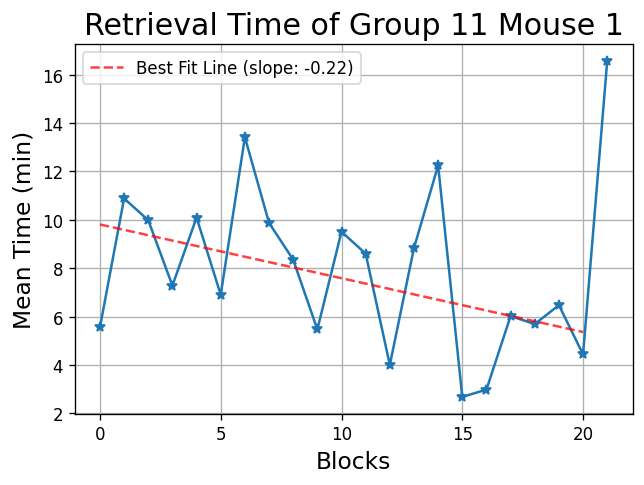

Mean retrieval time: 7.670264150943396 seconds
Standard deviation of retrieval time: 16.867687540059904 seconds
Slope of retrieval time: -0.22


In [12]:
times, mean, std = mean_pellet_collect_time(rev_ctrl_path, rev_ctrl_sheets[0], remove_outlier=True, n_stds=3, day=day)
_, pred, slope = plot_retrieval_time_by_block(rev_ctrl_path, rev_ctrl_sheets[0], day=day, n_stds=3,
                        export_path=None)

print("Mean retrieval time:", mean, 'seconds')
print("Standard deviation of retrieval time:", std, 'seconds')
print("Slope of retrieval time:", slope)

Congratulations!

You have finished the main functionalities of our packages provided for single mice. 

Please dive into details for `CASK_analysis` and `WT_analysis` for full pipelines on groups and more analysis beyond this starter! Happy coding!